# Ejemplos simulaciones

## Preeliminares

In [2]:
#Bibliotecas
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.visualization.scatter import Scatter
from tqdm import tqdm
from itertools import compress
import pypfopt
from pypfopt import EfficientFrontier,plotting
sns.set_theme()

## Algoritmos de No-Dominancia

In [3]:
def get_best_opt(data_portf,  n_feat, tol):
  portfolios = data_portf.iloc[:, :n_feat]
  portfolios = portfolios.to_numpy()
  indx = data_portf.index
  A = np.array( [[np.inf]*n_feat])
  best_idx = [np.inf]
  for idx,row in tqdm(zip(indx,portfolios)):
    test1 = (A <= row).all(axis=1)
    test2 = np.linalg.norm(A-row, ord=2, axis=1) > tol
    if not ((test1) & (test2)).any(): 
      A = np.vstack([A,row])
      best_idx.append(idx)
      test1 = (row <= A).all(axis=1)
      test2 = np.linalg.norm(row- A, ord=2, axis=1)> tol
      A = A[~((test1) & (test2)) ,:]
      best_idx = list(compress(best_idx,~((test1) & (test2))))
  return pd.DataFrame(A, index=best_idx, columns=data_portf.columns[:n_feat])

In [4]:
def get_best_opt_eps(data_portf, n_feat, tol, eps_array):
  eps_array = np.array(eps_array)
  portfolios = data_portf.iloc[:, :n_feat]
  portfolios = portfolios.to_numpy()
  indx = data_portf.index
  A = np.array( [[np.inf]*n_feat])
  best_idx = [np.inf]
  for  idx, row in tqdm(zip(indx, portfolios)):
    test1 = (A +eps_array<= row).all(axis=1)
    test2 = (np.linalg.norm(A+ (eps_array-row), ord=2, axis=1) > tol) 
    if not ((test1) & (test2)).any(): 
      A = np.vstack([A,row])
      best_idx.append(idx)
      test1 = (row +eps_array<= A).all(axis=1)
      test2 = np.linalg.norm( (row+eps_array)- A, ord=2, axis=1) > tol
      A = A[~((test1) & (test2)) ,:]
      best_idx = list(compress(best_idx,~((test1) & (test2))))
  return pd.DataFrame(A, index=best_idx, columns=data_portf.columns[:n_feat])

In [45]:
def dist_H( A, vec): 
    L = np.linalg.norm( A-vec, ord=2, axis=1)
    return np.min(L)

In [48]:
def get_best_opt_eps_H(data_portf, n_feat, tol, eps_array, delta):
  eps_array = np.array(eps_array)
  delta_array = np.array([delta]*n_feat)
  portfolios = data_portf.iloc[:, :n_feat]
  portfolios = portfolios.to_numpy()
  indx = data_portf.index
  
  A = np.array( [[np.inf]*n_feat])
  best_idx = [None]
  
  for  idx, row in tqdm(zip(indx, portfolios)): 
      test1 = (A +eps_array<= row).all(axis=1)
      test2 = np.linalg.norm(A+ eps_array-row, ord=2, axis=1) > tol 
      if not ((test1) & (test2)).any(): 
        if dist_H(A, row)>(delta/5):
          A = np.vstack([A,row])
          best_idx.append(idx)
          test1 = (row +eps_array +delta_array <= A).all(axis=1)
          test2 = np.linalg.norm( (row+eps_array+delta_array)- A, ord=2, axis=1) > tol
          A = A[~((test1) & (test2)) ,:]
          best_idx = list(compress(best_idx,~((test1) & (test2))))
  return pd.DataFrame(A, index=best_idx, columns=data_portf.columns[:n_feat])

## Análisis con los datos 

In [15]:
## NUMBER OF ASSETS
n_assets = 4

## NUMBER OF OBSERVATIONS
n_obs = 1000

def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)

def random_portfolio(returns):
    ''' 
    Returns the mean and standard deviation of returns for a random portfolio
    '''

    p = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(rand_weights(returns.shape[0]))
    C = np.asmatrix(np.cov(returns))
    
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)
    
    # This recursion reduces outliers to keep plots pretty
    if sigma > 2:
        return random_portfolio(returns)
    return mu, sigma

return_vec = np.random.randn(n_assets, n_obs)
n_portfolios = 10000
means, stds = np.column_stack([
    random_portfolio(return_vec) 
    for _ in range(n_portfolios)
])

In [16]:
P1_df = pd.DataFrame( np.concatenate((-means, stds), axis=1), columns=['Var1', 'Var2'])
P1_df.head()

,Var1,Var2
0,0.009211,0.549990
1,0.023480,0.612181
2,0.023000,0.557186
3,0.027307,0.536039
4,0.047764,0.800022


<AxesSubplot:>

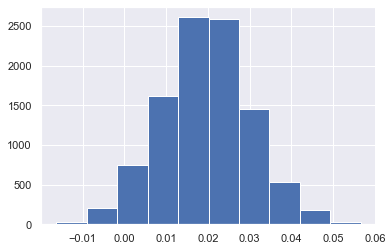

In [23]:
P1_df['Var1'].hist()

<AxesSubplot:>

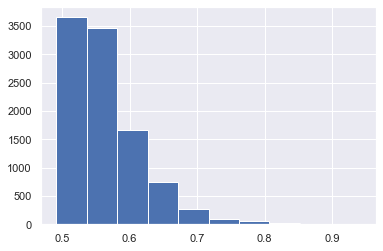

In [24]:
P1_df['Var2'].hist()

In [22]:
A = get_best_opt(P1_df,2 , 1e-6)
A.shape

10000it [00:00, 28721.44it/s]


(134, 2)

In [25]:
A2 = get_best_opt_eps(P1_df, 2, 1e-6, [0.001, 0.01])
A2.shape

10000it [00:01, 8745.06it/s]


(1667, 2)

In [50]:
A3 = get_best_opt_eps_H(P1_df, 2, 1e-6, [0.001, 0.01], 0.01)
A3.shape

10000it [00:00, 16707.57it/s]


(149, 2)

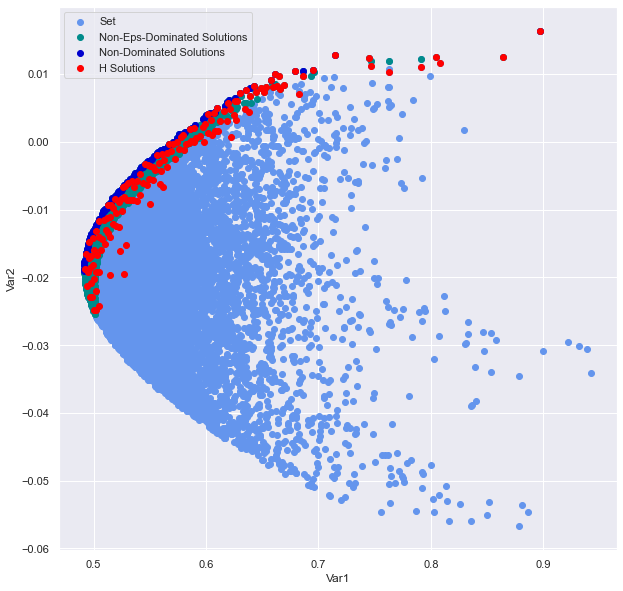

In [51]:
fig = plt.figure(figsize=(10, 10))
plt.scatter(P1_df['Var2'], -P1_df['Var1'], c='cornflowerblue', label='Set')
plt.scatter(A2['Var2'], - A2['Var1'], c='darkcyan', label='Non-Eps-Dominated Solutions')
plt.scatter(A['Var2'], -A['Var1'],c ='mediumblue', label='Non-Dominated Solutions' )
plt.scatter(A3['Var2'], -A3['Var1'], c='red', label='H Solutions')
plt.xlabel('Var1')
plt.ylabel('Var2')
plt.legend()
